In [1]:
import os
import cv2
import numpy as np
from skimage.io import imread
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, log_loss
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
import random


In [2]:
def process_machineproject(machineproject_path, str):
    # Construct the paths to the images and labels folders
    images_folder = os.path.join(machineproject_path, str, "images")
    labels_folder = os.path.join(machineproject_path, str, "labels")

    # Initialize lists for images and labels and hog features
    image_list = []
    label_list = []
    #hog_features = []
    
    # Iterate through label files and check the conditions
    for label_file in os.listdir(labels_folder):
        label_file_path = os.path.join(labels_folder, label_file)

        # Check if the file is not empty
        if os.path.getsize(label_file_path) > 0:
            with open(label_file_path, "r") as label_file:
                # Read the first character of the label
                first_letter = label_file.read(1)

                # Check conditions based on the first letter
                if first_letter == '2':
                    label_list.append(0)  # Encoding 'Fresh' as 0
                elif first_letter == '3':
                    label_list.append(1)  # Encoding 'Rotten' as 1
                else:
                    label_list.append(-1)  # Encoding 'Unknown' as -1
                

            # Append the image filename to the image list
            image_filename = label_file.name.replace(".txt", ".jpg")  # Assuming image files have .jpg extension
            image_path = os.path.join(images_folder, image_filename)
            image_list.append(image_path)


        else:
            label_list.append(-1)
    #image_features = extract_sift_features(image_list)

    return image_list, label_list

In [3]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    features = []

    for label_file_path in images:
        try:
            # Extract the image filename from the label file path
            image_filename = os.path.basename(label_file_path).replace(".txt", ".jpg")

            # Correct the folder name to "images" in the path
            corrected_image_path = label_file_path.replace("labels", "images").replace(image_filename, "")

            # Remove any extra "images" folder in the path
            corrected_image_path = corrected_image_path.replace("\\images", "\\images")

            # Construct the correct path to the image in the "images" folder
            image_path = os.path.join(corrected_image_path, image_filename)

            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

            # Check if the image is loaded successfully
            if img is None:
                print(f"Error loading image: {image_path}")
                features.append(np.array([]))
                continue

            # Check if the image is not empty
            if img.size == 0:
                print(f"Empty image: {image_path}")
                features.append(np.array([]))
                continue

            keypoints, descriptors = sift.detectAndCompute(img, None)

            # Check if keypoints and descriptors are obtained
            if descriptors is not None and descriptors.shape[0] > 0:
                # Pad or truncate descriptors to a fixed size (e.g., 128)
                descriptor_size = 128
                if descriptors.shape[0] < descriptor_size:
                    descriptors = np.pad(descriptors, ((0, descriptor_size - descriptors.shape[0]), (0, 0)))
                elif descriptors.shape[0] > descriptor_size:
                    descriptors = descriptors[:descriptor_size, :]
                features.append(descriptors.flatten())
            else:
                print(f"No keypoints or descriptors found for image: {image_path}")
                features.append(np.zeros(128))  # Use a placeholder value for empty cases

        except Exception as e:
            print(f"Error processing image: {image_path}, Exception: {str(e)}")
            features.append(np.zeros(128))  # Use a placeholder value for exceptions

    return np.array(features)

In [4]:
def removeunknown (image_list,label_list):
    indices_to_remove = [i for i, label in enumerate(label_list) if label == -1]
    for index in reversed(indices_to_remove):
        label_list.pop(index)
        image_list.pop(index)


In [5]:
machineproject_path = 'E:\\.college\\ML\\Tomato_Image_Detection'

In [6]:
xtrain, ytrain = process_machineproject(machineproject_path, 'train')
removeunknown(xtrain, ytrain)
y_train_encoded = np.array(ytrain)

In [7]:
xtest, ytest = process_machineproject(machineproject_path, 'test')
removeunknown(xtest,ytest)
y_test_encoded = np.array(ytest)


In [8]:
xval, yval = process_machineproject(machineproject_path, 'val')
removeunknown(xval, yval)
y_val_encoded = np.array(yval)

In [9]:
#print the results after removing unknown and empty data
for image, label in zip(xtrain, ytrain):
    print(f"Image: {image}, Label: {label}")

Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-1-_jpg.rf.6fef6f805a76de1108a4ca5e95c8a4ea.jpg, Label: 1
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-1-_jpg.rf.e8d546d604870181a0593fed28ea7d1a.jpg, Label: 1
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.195ed6cac6c0ba79c092ae4cb4e9f63f.jpg, Label: 1
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.2be315ced120d7ff0986b02cd5bcf769.jpg, Label: 1
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.98adb8e9ac1637feb04c81350da29cff.jpg, Label: 1
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.9d7bd4ee7f6310bbeb33232051d86ad4.jpg, Label: 1
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.abd8729e81388747afebd653d278292a.jpg, Label: 1
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.ce734ba0cf68dae4756a1db24ce9592a.jpg, Label: 1
Im

In [10]:
image_features = extract_sift_features(xtrain)
test_features = extract_sift_features(xtest)
val_features = extract_sift_features(xval)

In [11]:
#print results after sift 
for image, label, feature in zip(xtrain, ytrain, image_features):
    print(f"Image: {image}, Label: {label}, Feature: {feature}")

Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-1-_jpg.rf.6fef6f805a76de1108a4ca5e95c8a4ea.jpg, Label: 1, Feature: [65. 87.  0. ...  0.  2. 71.]
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-1-_jpg.rf.e8d546d604870181a0593fed28ea7d1a.jpg, Label: 1, Feature: [  0.   0.   0. ...   0.   5. 108.]
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.195ed6cac6c0ba79c092ae4cb4e9f63f.jpg, Label: 1, Feature: [29.  0.  0. ...  1.  1. 40.]
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.2be315ced120d7ff0986b02cd5bcf769.jpg, Label: 1, Feature: [  0.   0.   0. ... 138.   1.   0.]
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.98adb8e9ac1637feb04c81350da29cff.jpg, Label: 1, Feature: [20. 16.  4. ...  0.  0.  0.]
Image: E:\.college\ML\Tomato_Image_Detection\train\labels\very-bad-10-_jpg.rf.9d7bd4ee7f6310bbeb33232051d86ad4.jpg, Label: 1, Feature: [ 7. 50. 78. ... 17.  3. 18.]


In [12]:
# Step 3: Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(image_features)
X_test_scaled = scaler.transform(test_features)
X_val_scaled = scaler.transform(val_features)

In [13]:
if X_train_scaled.shape[0] != y_train_encoded.shape[0]:
    y_train_encoded = y_train_encoded[:-1]

# Check the shape of X_train_scaled and y_train_encoded
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of y_train_encoded:", y_train_encoded.shape)

kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_train_scaled)
"""
# Train the Logistic Regression model
model = LogisticRegression(random_state=42, max_iter=1000)

try:
    model.fit(X_train_scaled, y_train_encoded)
except ValueError as e:
    print("Error:", e)
    """

Shape of X_train_scaled: (2315, 16384)
Shape of y_train_encoded: (2315,)


'\n# Train the Logistic Regression model\nmodel = LogisticRegression(random_state=42, max_iter=1000)\n\ntry:\n    model.fit(X_train_scaled, y_train_encoded)\nexcept ValueError as e:\n    print("Error:", e)\n    '

In [14]:
#error mn awel hena
# Step 5: Evaluate the Model
y_pred_train = kmeans.predict(X_train_scaled)
y_pred_test = kmeans.predict(X_test_scaled)
y_pred_val = kmeans.predict(X_val_scaled)

In [15]:
# For training set
if len(y_pred_train) != len(ytrain):
    ytrain = ytrain[:-1]  # Adjust the length of ytrain

# For testing set
if len(y_pred_test) != len(ytest):
    ytest = ytest[:-1]  # Adjust the length of ytest

# For validation set
if len(y_pred_val) != len(yval):
    yval = yval[:-1]


accuracy_train = accuracy_score(ytrain, y_pred_train)
accuracy_test = accuracy_score(ytest, y_pred_test)
accuracy_val = accuracy_score(yval, y_pred_val)

print(f"Accuracy on Training Set: {accuracy_train}")
print(f"Accuracy on Testing Set: {accuracy_test}")
print(f"Accuracy on Validation Set: {accuracy_val}")

Accuracy on Training Set: 0.5395248380129589
Accuracy on Testing Set: 0.7116883116883117
Accuracy on Validation Set: 0.6296875


In [16]:
from sklearn.metrics import silhouette_score

# Compute silhouette scores
silhouette_train = silhouette_score(X_train_scaled, y_pred_train)
silhouette_test = silhouette_score(X_test_scaled, y_pred_test)
silhouette_val = silhouette_score(X_val_scaled, y_pred_val)

print(f"Silhouette Score on Training Set: {silhouette_train}")
print(f"Silhouette Score on Testing Set: {silhouette_test}")
print(f"Silhouette Score on Validation Set: {silhouette_val}")


Silhouette Score on Training Set: 0.00745778251439333
Silhouette Score on Testing Set: 0.06611543148756027
Silhouette Score on Validation Set: 0.04363115504384041


In [21]:
# Randomly sample a subset of data
sample_size = 2315  # Adjust the sample size as needed
random.seed(42)  # Set a seed for reproducibility
sample_indices = random.sample(range(X_train_scaled.shape[0]), sample_size)
X_train_sampled = X_train_scaled[sample_indices, :]

In [22]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=100)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_sampled)


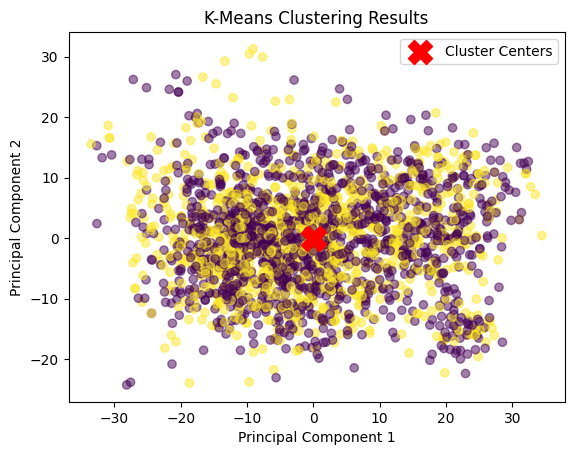

In [23]:
#visualize data points and clusters
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Cluster Centers')
plt.title('K-Means Clustering Results')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()